# Description
This notebook prepares a plot comparing the MCMC estimated model with the data.

In [1]:
import numpy
import arviz
import pymc3
import pandas
from matplotlib import pyplot
import fastprogress
import pathlib

import murefi
import calibr8

import models
import plotting

DP_FIGURES = pathlib.Path("figures")
DP_PROCESSED = pathlib.Path("processed")

### Read models and dataset

In [2]:
cm_biomass = models.get_biomass_model()
cm_glucose = models.get_glucose_model()
model = models.MonodModel()
dataset = murefi.load_dataset(DP_PROCESSED / "cultivation_dataset.h5")
theta_mapping = models.get_parameter_mapping()
idata = arviz.from_netcdf(DP_PROCESSED / "full_posterior.nc")
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

Warmup iterations saved (warmup_*).

In [3]:
rids = ["B06"]

parameters = plotting.extract_parameters(idata, theta_mapping, nmax=5000)
print("Predicting like the data...")
pds_data = model.predict_dataset(
    template={rid: rep for rid, rep in dataset.items() if rid in rids},
    parameter_mapping=theta_mapping,
    parameters=parameters,
)
print("Predicting for extrapolation...")
pds_extra = model.predict_dataset(
    template={
        rid: murefi.Replicate.make_template(
            tmin=0, tmax=10, independent_keys="SX", rid=rid
        )
        for rid in rids
    },
    parameter_mapping=theta_mapping,
    parameters=parameters,
)
print("Done.")

Predicting like the data...
Predicting for extrapolation...
Done.


c:\users\osthege\repos\calibr8\calibr8\core.py:936: RuntimeWarning: divide by zero encountered in log10
  y = (numpy.exp(s2 * (s3 * (log_I_x - numpy.log10(x)) + c / s2)) + 1) ** -s1


c:\users\osthege\repos\calibr8\calibr8\core.py:936: RuntimeWarning: invalid value encountered in log10
  y = (numpy.exp(s2 * (s3 * (log_I_x - numpy.log10(x)) + c / s2)) + 1) ** -s1


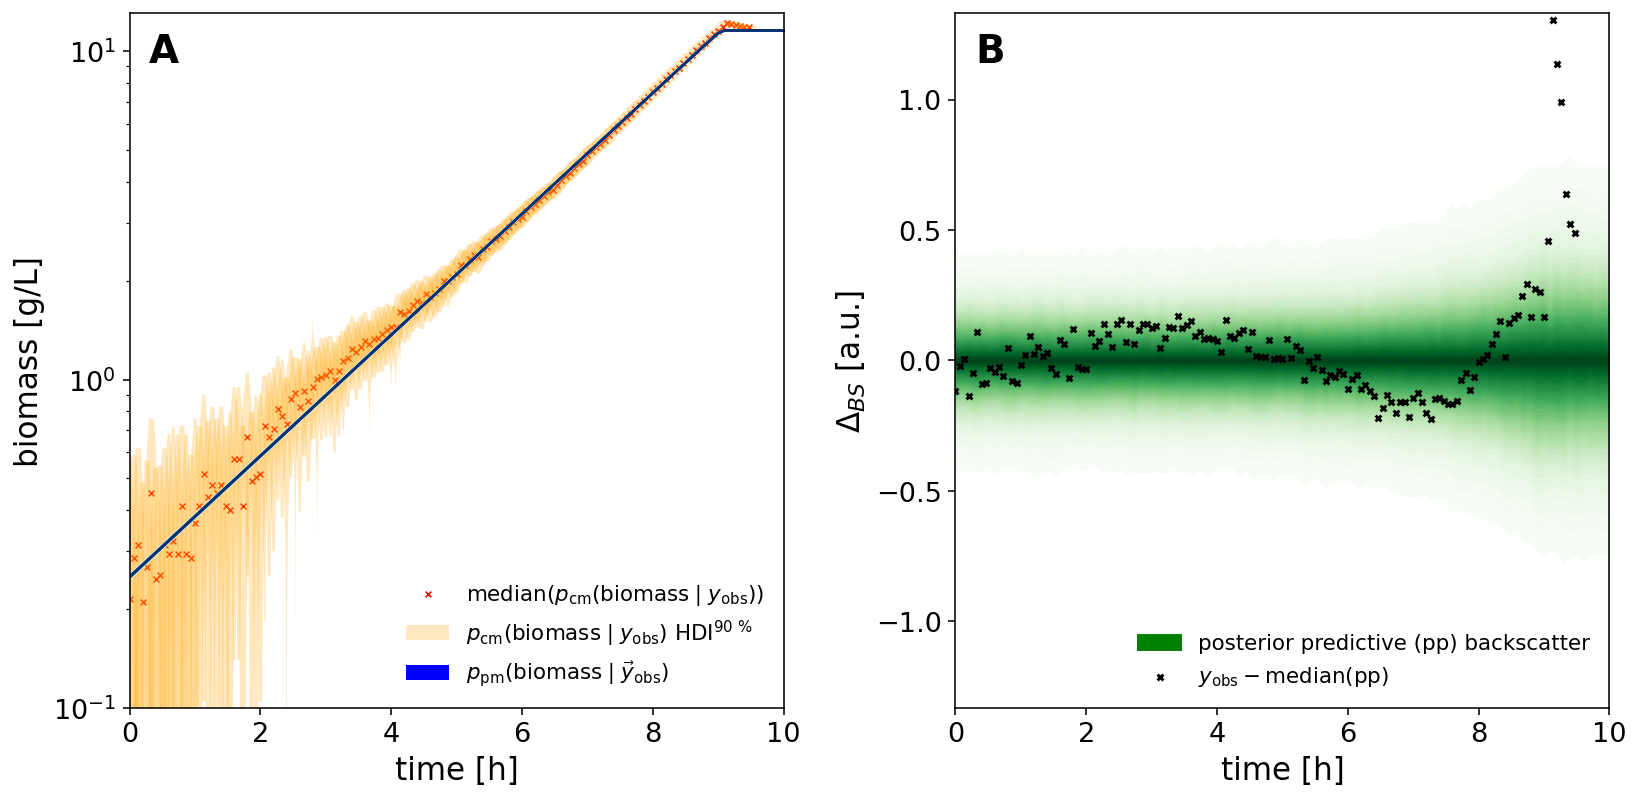

In [4]:
fig, axs = pyplot.subplots(dpi=140, figsize=(12, 6), nrows=1, ncols=2, sharex=True)

# auxilliary variables
rid = rids[0]
rep = dataset[rid]
tsx = rep["Pahpshmir_1400_BS3_CgWT"]
tsxpred = pds_data[rid][tsx.dependent_key]

# LEFT
ax = axs[0]
ax.scatter(
    x=tsx.t,
    y=[
        cm_biomass.infer_independent(y, lower=0, upper=20).median
        for y in fastprogress.progress_bar(tsx.y)
    ],
    color="red",
    marker="x",
    linewidths=0.8,
)
for t, y in fastprogress.progress_bar(list(zip(tsx.t, tsx.y))):
    pst = cm_biomass.infer_independent(y, lower=0, upper=20, ci_prob=0.9)
    ax.fill_betweenx(
        y=pst.hdi_x,
        x1=t - pst.hdi_pdf / 20,
        x2=t + pst.hdi_pdf / 20,
        color="orange",
        alpha=0.25,
        edgecolor=None,
    )
pymc3.gp.util.plot_gp_dist(
    ax=ax,
    x=pds_extra[rid]["X"].t,
    samples=pds_extra[rid]["X"].y,
    palette="Blues",
    plot_samples=False,
)
ax.legend(
    handles=[
        ax.scatter(
            [],
            [],
            color="red",
            marker="x",
            linewidths=0.8,
            label=r"median($p_\mathrm{cm}(\mathrm{biomass} \mid y_\mathrm{obs})$)",
        ),
        ax.fill_between(
            [],
            [],
            color="orange",
            edgecolor=None,
            alpha=0.25,
            label=r"$p_\mathrm{cm}(\mathrm{biomass} \mid y_\mathrm{obs})\ \mathrm{HDI}^{90\ \%}$",
        ),
        ax.fill_between(
            [],
            [],
            color="blue",
            edgecolor=None,
            alpha=1,
            label=r"$p_\mathrm{pm}(\mathrm{biomass} \mid \vec{y}_\mathrm{obs})$",
        ),
    ],
    loc="lower right",
)

# RIGHT
ax = axs[1]
resmax = plotting.plot_residuals_pp(
    ax,
    cm_biomass,
    tsx,
    tsxpred,
    color="black",
    palette="Greens",
    # plot a higher-resolution, extrapolated density
    tspred_extra=pds_extra[rid]["X"],
)
ax.legend(
    handles=[
        ax.fill_between(
            [], [], color="green", label="posterior predictive (pp) backscatter"
        ),
        ax.scatter(
            [],
            [],
            color="black",
            marker="x",
            label="$y_\mathrm{obs} - \mathrm{median(pp)}$",
        ),
    ],
    loc="lower right",
)

# formatting
# LEFT
ax = axs[0]
ax.set_ylim(0.1)
ax.set_yscale("log")
ax.set_ylabel("biomass [g/L]")
ax.set_xlabel("time [h]")
# RIGHT
ax = axs[1]
ax.set_ylabel(r"$\Delta_{BS}$ [a.u.]")
ax.set_ylim(-resmax * 1.02, resmax * 1.02)
ax.set_xlabel("time [h]")
ax.set_xlim(0, 10)

# Mark subplots with A, B, ...
for i, ax in enumerate(axs):
    ax.text(0.03, 0.93, "AB"[i], transform=ax.transAxes, size=20, weight="bold")

fig.tight_layout()
plotting.savefig(fig, "4.2.4 Log-CDW and Monod Residuals")
pyplot.show()

In [5]:
%load_ext watermark
%watermark

Last updated: 2021-12-15T10:29:50.292127+01:00

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.24.1

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 6
Architecture: 64bit

